## Can We Predict If A Startup Will Be Acquired?

In [1]:
!pip install imbalanced-learn
!pip install category_encoders
!pip install scikit-learn==1.0.1

In [2]:
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
filepath = "Startup Investment Dataset/updated_Mf_company_3.csv"
startups = pd.read_csv(filepath)
print(startups.shape)
startups.head()

(196553, 15)


,id,entity_id,name,category_code,status,overview,country_code,city,region,funding_rounds,funding_total_usd,founded_at,founded_year,founded_month,founded_month_year
0,c:1,1,Wetpaint,web,operating,Wetpaint is a technology platform company that...,USA,Seattle,Seattle,3,39750000,2005-10-17,2005.0,10.0,2005-10
1,c:10,10,Flektor,games_video,acquired,Flektor is a rich-media mash-up platform that ...,USA,Culver City,Los Angeles,0,0,2006-05-01,2006.0,5.0,2006-05
2,c:100,100,There,games_video,acquired,There.com is an online virtual world where any...,USA,San Mateo,SF Bay,0,0,1999-01-01,1999.0,1.0,1999-01
3,c:10000,10000,MYWEBBO,network_hosting,operating,"BRAND NEW ONLINE SOCIAL NETWORKING WEBSITE,FOR...",NaN,NaN,unknown,0,0,2008-07-26,2008.0,7.0,2008-07
4,c:10001,10001,THE Movie Streamer,games_video,operating,This company shows free movies online on their...,NaN,NaN,unknown,0,0,2008-07-26,2008.0,7.0,2008-07


### Data Cleaning for Data Modeling


In [4]:
# Select 21st Century data

startups = startups[startups['founded_year'] >= 2000]
print(startups.shape)

(111864, 15)


In [5]:
# Drop unnecessary columns

startups.drop(columns=['entity_id','name','overview'],inplace=True)
startups.head()

,id,category_code,status,country_code,city,region,funding_rounds,funding_total_usd,founded_at,founded_year,founded_month,founded_month_year
0,c:1,web,operating,USA,Seattle,Seattle,3,39750000,2005-10-17,2005.0,10.0,2005-10
1,c:10,games_video,acquired,USA,Culver City,Los Angeles,0,0,2006-05-01,2006.0,5.0,2006-05
3,c:10000,network_hosting,operating,NaN,NaN,unknown,0,0,2008-07-26,2008.0,7.0,2008-07
4,c:10001,games_video,operating,NaN,NaN,unknown,0,0,2008-07-26,2008.0,7.0,2008-07
5,c:10002,advertising,operating,MAR,Agadir,Agadir,0,0,2007-06-27,2007.0,6.0,2007-06


In [6]:
startups['status'].value_counts().sort_index()

acquired       3975
closed         2022
ipo             337
operating    105530
Name: status, dtype: int64

In [7]:
# Exclude closed startups as they cannot be acquired

startups = startups[startups["status"].isin(['acquired','operating','ipo'])]
print(startups.shape)

(109842, 12)


In [8]:
# Drop missing rows

startups.dropna(inplace=True)
startups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53981 entries, 0 to 196552
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  53981 non-null  object 
 1   category_code       53981 non-null  object 
 2   status              53981 non-null  object 
 3   country_code        53981 non-null  object 
 4   city                53981 non-null  object 
 5   region              53981 non-null  object 
 6   funding_rounds      53981 non-null  int64  
 7   funding_total_usd   53981 non-null  int64  
 8   founded_at          53981 non-null  object 
 9   founded_year        53981 non-null  float64
 10  founded_month       53981 non-null  float64
 11  founded_month_year  53981 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 5.4+ MB


In [9]:
# Create new column 'acquired' which is the value to be predicted

startups["acquired"] = (startups['status'] == 'acquired').apply(int)
print(startups.shape)
startups.head()

(53981, 13)


,id,category_code,status,country_code,city,region,funding_rounds,funding_total_usd,founded_at,founded_year,founded_month,founded_month_year,acquired
0,c:1,web,operating,USA,Seattle,Seattle,3,39750000,2005-10-17,2005.0,10.0,2005-10,0
1,c:10,games_video,acquired,USA,Culver City,Los Angeles,0,0,2006-05-01,2006.0,5.0,2006-05,1
5,c:10002,advertising,operating,MAR,Agadir,Agadir,0,0,2007-06-27,2007.0,6.0,2007-06,0
6,c:10003,cleantech,operating,IND,Vadodara,Vadodara,0,0,2008-08-20,2008.0,8.0,2008-08,0
12,c:10009,advertising,operating,USA,Santa Fe,Santa Fe,0,0,2008-08-01,2008.0,8.0,2008-08,0


In [10]:
startups["acquired"].value_counts()

0    51005
1     2976
Name: acquired, dtype: int64

Check for Incorrect/Missing/Invalid funding amounts and Outliers

In [11]:
# Check % of data where funding amount is 0

print(len(startups[startups.funding_total_usd==0])/len(startups)*100)

67.11065004353384


In [12]:
# For funding amt=0, check what are no. of funding rounds

funding_0 = startups[startups.funding_total_usd==0]
funding_0['funding_rounds'].value_counts()

0    34130
1     1850
2      208
3       31
4        6
5        2
Name: funding_rounds, dtype: int64

In [13]:
print(funding_0[(funding_0['funding_rounds']==3) & (funding_0['funding_total_usd']==0)][['id']].head())
print(funding_0[(funding_0['funding_rounds']==3) & (funding_0['funding_total_usd']==0)][['id']].tail())

             id
2750    c:11843
8587   c:142873
11782   c:14710
12327   c:14785
15055  c:151711
             id
185656  c:75058
185999  c:75513
187598    c:775
193698  c:84848
193815    c:850


In [14]:
# Check no. and % of data where funding amt=0 but funding rounds>0

print(len(funding_0[(funding_0['funding_rounds']>0) & (funding_0['funding_total_usd']==0)]))
print(len(funding_0[(funding_0['funding_rounds']>0) & (funding_0['funding_total_usd']==0)])/len(funding_0)*100.0)

2097
5.78850028983907


There should be no data where we have 1 or more funding rounds but 0 funding amounts raised. 

Hence, we deep-dive into the data to evaluate possible reasons for this

In [15]:
company = pd.read_csv("Startup Investment Dataset/updated_objects_company.csv")
company[company['id'].isin(['c:11843', 'c:850', 'c:75058'])][['id', 'name']]

,id,name
2750,c:11843,Green Plug
185656,c:75058,PriceMe
193815,c:850,Jamdat Mobile


https://www.crunchbase.com/organization/jamdatmobile/company_financials

JAMDAT Mobile has raised a total of $29M in funding over 3 rounds. Their latest funding was raised on Dec 4, 2003 from a Series D round.

https://www.crunchbase.com/organization/green-plug/company_financials

Green Plug has had multiple successful funding rounds but the data is unavailable online.

https://www.crunchbase.com/organization/priceme/company_financials

Price Me also has had multiple successful funding rounds but the data is unavailable online.

Hence, we see that when funding rounds > 0 but funding amount = 0, there is missing or incorrect data. 

Hence, we exclude these rows.

In [16]:
print(startups.shape)
startups = startups[(startups['funding_rounds']==0) | (startups['funding_total_usd']!=0)]
print(startups.shape)

(53981, 13)
(51884, 13)


We now look at funding round data distribution to identify and remove outliers

<AxesSubplot:ylabel='Frequency'>

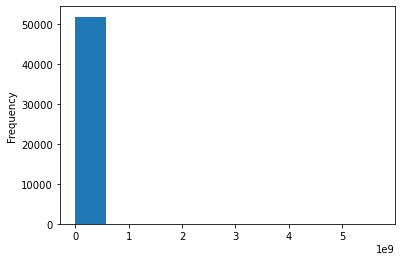

In [17]:
startups['funding_total_usd'].plot.hist()

Text(0.5, 1.0, 'Funding Amount Before Outlier Removal')

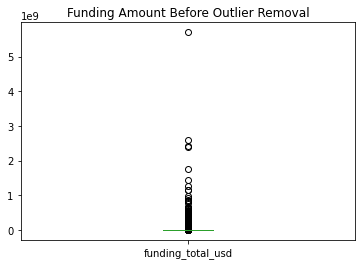

In [18]:
startups['funding_total_usd'].plot.box()
plt.title("Funding Amount Before Outlier Removal")

In [19]:
summary_stats = startups['funding_total_usd'].describe()
summary_stats

count    5.188400e+04
mean     5.094850e+06
std      4.157508e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.057375e+05
max      5.700000e+09
Name: funding_total_usd, dtype: float64

Outliers can be considered as values outside the (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR) range, where IQR = (Q3−Q1)


In [20]:
iqr = summary_stats['75%'] - summary_stats['25%']
min_val = max(summary_stats['min'],(summary_stats['25%'] - (1.5 * iqr)))
max_val = min(summary_stats['max'], (summary_stats['75%'] + (1.5 * iqr)))
print("IQR = ",iqr)
print("Min val of range = ",min_val)
print("Max val of range = ",max_val)

IQR =  605737.5
Min val of range =  0.0
Max val of range =  1514343.75


Text(0.5, 1.0, 'Funding Amount After Outlier Removal')

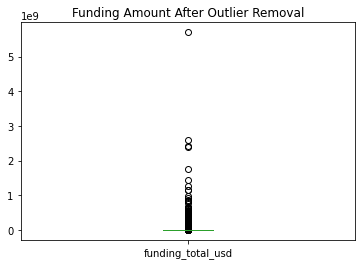

In [21]:
startups['funding_total_usd'].plot.box()
plt.title("Funding Amount After Outlier Removal")

We have removed outliers, but the funding amounts are distributed over a wide range of values (0,1.5e6).

We need to standardize this values to a (0,1) range to ensure strong model

(51884, 13)
(41527, 13)


Text(0.5, 1.0, 'Funding Amount Before Standardization')

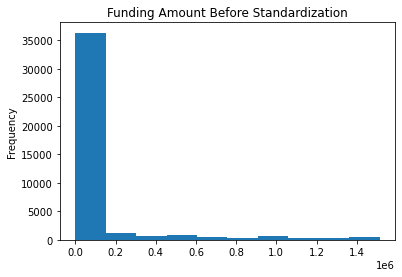

In [22]:
print(startups.shape)
startups = startups[startups['funding_total_usd']<=max_val]
print(startups.shape)
startups['funding_total_usd'].plot.hist()
plt.title("Funding Amount Before Standardization")

In [23]:
startups['funding_total_usd'].describe()

count    4.152700e+04
mean     9.173543e+04
std      2.726417e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.513946e+06
Name: funding_total_usd, dtype: float64

In [24]:
scaler = MinMaxScaler()
scaled_val = scaler.fit_transform(startups[['funding_total_usd']])
scaled_val

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.49539416],
       [0.        ],
       [0.31374963]])

In [25]:
startups['funding_total_usd'] = scaled_val
startups.head()

,id,category_code,status,country_code,city,region,funding_rounds,funding_total_usd,founded_at,founded_year,founded_month,founded_month_year,acquired
1,c:10,games_video,acquired,USA,Culver City,Los Angeles,0,0.0,2006-05-01,2006.0,5.0,2006-05,1
5,c:10002,advertising,operating,MAR,Agadir,Agadir,0,0.0,2007-06-27,2007.0,6.0,2007-06,0
6,c:10003,cleantech,operating,IND,Vadodara,Vadodara,0,0.0,2008-08-20,2008.0,8.0,2008-08,0
12,c:10009,advertising,operating,USA,Santa Fe,Santa Fe,0,0.0,2008-08-01,2008.0,8.0,2008-08,0
15,c:10011,games_video,operating,USA,Julian,San Diego,0,0.0,2008-01-01,2008.0,1.0,2008-01,0


In [26]:
startups['funding_total_usd'].describe()

count    41527.000000
mean         0.060594
std          0.180087
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: funding_total_usd, dtype: float64

Text(0.5, 1.0, 'Funding Amount After Standardization')

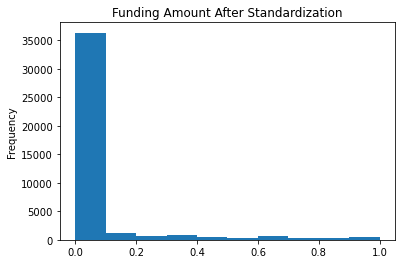

In [27]:
startups['funding_total_usd'].plot.hist()
plt.title("Funding Amount After Standardization")

Analyzing correlation between numerical columns

In [28]:
s_corr = startups.corr()
s_corr

,funding_rounds,funding_total_usd,founded_year,founded_month,acquired
funding_rounds,1.000000,0.679750,0.134535,-0.027023,0.013374
funding_total_usd,0.679750,1.000000,0.070802,-0.064987,0.027589
founded_year,0.134535,0.070802,1.000000,0.122215,-0.143963
founded_month,-0.027023,-0.064987,0.122215,1.000000,-0.050362
acquired,0.013374,0.027589,-0.143963,-0.050362,1.000000


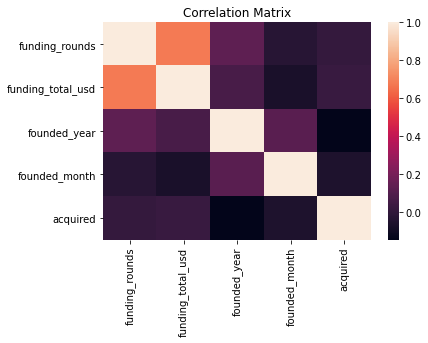

In [29]:
sns.heatmap(s_corr)
plt.title("Correlation Matrix")
plt.show()

In [30]:
# Create final cleaned dataframe

startups_2 = startups.drop(columns=['id', 'status', 'founded_month_year', 'founded_at'])
startups_2['founded_year'] = startups_2['founded_year'].astype(int).astype(str)
startups_2['founded_month'] = startups_2['founded_month'].astype(int).astype(str)
startups_2.reset_index(inplace=True, drop=True)
startups_2.head()

,category_code,country_code,city,region,funding_rounds,funding_total_usd,founded_year,founded_month,acquired
0,games_video,USA,Culver City,Los Angeles,0,0.0,2006,5,1
1,advertising,MAR,Agadir,Agadir,0,0.0,2007,6,0
2,cleantech,IND,Vadodara,Vadodara,0,0.0,2008,8,0
3,advertising,USA,Santa Fe,Santa Fe,0,0.0,2008,8,0
4,games_video,USA,Julian,San Diego,0,0.0,2008,1,0


#### Feature Engineering and Train-Test Data Split

Balancing Data

In [31]:
X = startups_2[['category_code', 'funding_rounds','country_code','city', 'region',
              'funding_total_usd', 'founded_year', 'founded_month']]
y = startups_2['acquired']

In [32]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
print(X_resampled.head())
print(y_resampled.head())

[(0, 1492), (1, 1492)]
  category_code  funding_rounds country_code       city     region  \
0      software               0          GBR     London     London   
1     ecommerce               0          USA   New York   New York   
2      software               0          GBR      Essex      Essex   
3         other               0          IND  Bangalore  Bangalore   
4   games_video               0          USA    Oakland     SF Bay   

   funding_total_usd founded_year founded_month  
0                0.0         2013             2  
1                0.0         2007            12  
2                0.0         2009            10  
3                0.0         2009             5  
4                0.0         2004             1  
0    0
1    0
2    0
3    0
4    0
Name: acquired, dtype: int64


Converting categorical data into binary encoded data

Reference Link for Encoding Method Details is below:

* https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159


In [33]:
for i in X_resampled.columns:
    print("Column ", i, " has ", len(startups_2[i].value_counts()), "distinct values")

Column  category_code  has  42 distinct values
Column  funding_rounds  has  11 distinct values
Column  country_code  has  155 distinct values
Column  city  has  6790 distinct values
Column  region  has  3834 distinct values
Column  funding_total_usd  has  2124 distinct values
Column  founded_year  has  15 distinct values
Column  founded_month  has  12 distinct values


In [34]:
print(X_resampled.shape)

(2984, 8)


In [35]:
column_list = ['category_code', 'country_code', 'city', 'region', 'founded_year', 'founded_month']

encoded_df = pd.DataFrame()

for i in column_list:
    he = ce.HashingEncoder(n_components=8, drop_invariant=True, return_df=True)
    df = he.fit_transform(X_resampled[i], y_resampled) 
    df = df.add_prefix(i + "_")
    encoded_df = pd.concat([encoded_df, df], axis=1)
    
print(encoded_df.shape)
print(encoded_df.columns)
encoded_df.head()

(2984, 46)
Index(['category_code_col_0', 'category_code_col_1', 'category_code_col_2',
       'category_code_col_3', 'category_code_col_4', 'category_code_col_5',
       'category_code_col_6', 'category_code_col_7', 'country_code_col_0',
       'country_code_col_1', 'country_code_col_2', 'country_code_col_3',
       'country_code_col_4', 'country_code_col_5', 'country_code_col_6',
       'country_code_col_7', 'city_col_0', 'city_col_1', 'city_col_2',
       'city_col_3', 'city_col_4', 'city_col_5', 'city_col_6', 'city_col_7',
       'region_col_0', 'region_col_1', 'region_col_2', 'region_col_3',
       'region_col_4', 'region_col_5', 'region_col_6', 'region_col_7',
       'founded_year_col_0', 'founded_year_col_1', 'founded_year_col_2',
       'founded_year_col_3', 'founded_year_col_4', 'founded_year_col_5',
       'founded_year_col_6', 'founded_year_col_7', 'founded_month_col_0',
       'founded_month_col_2', 'founded_month_col_3', 'founded_month_col_4',
       'founded_month_col_5', 

,category_code_col_0,category_code_col_1,category_code_col_2,category_code_col_3,category_code_col_4,category_code_col_5,category_code_col_6,category_code_col_7,country_code_col_0,country_code_col_1,...,founded_year_col_4,founded_year_col_5,founded_year_col_6,founded_year_col_7,founded_month_col_0,founded_month_col_2,founded_month_col_3,founded_month_col_4,founded_month_col_5,founded_month_col_6
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


In [36]:
X_resampled.drop(columns=column_list, inplace=True)
X_resampled = pd.concat([X_resampled, encoded_df], axis=1)
print(X_resampled.shape)
X_resampled.head()

(2984, 48)


,funding_rounds,funding_total_usd,category_code_col_0,category_code_col_1,category_code_col_2,category_code_col_3,category_code_col_4,category_code_col_5,category_code_col_6,category_code_col_7,...,founded_year_col_4,founded_year_col_5,founded_year_col_6,founded_year_col_7,founded_month_col_0,founded_month_col_2,founded_month_col_3,founded_month_col_4,founded_month_col_5,founded_month_col_6
0,0,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0.0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0.0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


Split data into train and test sets with 80-20 split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20)
print(X_train.shape, sorted(Counter(y_train).items()))
print(X_test.shape, sorted(Counter(y_test).items()))

(2387, 48) [(0, 1201), (1, 1186)]
(597, 48) [(0, 291), (1, 306)]


### Data Modeling

##### Baseline Model - Decision Tree Classifier

In [38]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("Accuracy = "+ str(round(score*100,2)) + "%")

Accuracy = 58.96%


              precision    recall  f1-score   support

           0       0.58      0.59      0.59       291
           1       0.60      0.58      0.59       306

    accuracy                           0.59       597
   macro avg       0.59      0.59      0.59       597
weighted avg       0.59      0.59      0.59       597



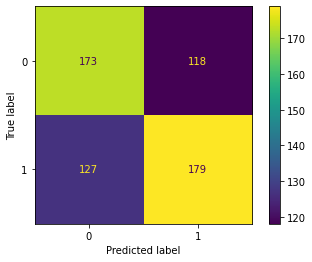

In [39]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

<AxesSubplot:>

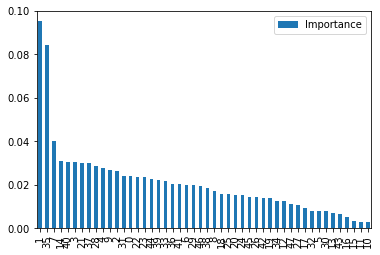

In [40]:
feature_imp = pd.DataFrame({'Feature': X_resampled.columns, 'Importance': clf.feature_importances_})
feature_imp.sort_values(by='Importance', inplace=True, ascending=False)
feature_imp.plot.bar()

                Feature  Importance
1     funding_total_usd    0.095243
35   founded_year_col_1    0.084309
7   category_code_col_5    0.039881
14   country_code_col_4    0.030877
40   founded_year_col_6    0.030552
3   category_code_col_1    0.030357
21           city_col_3    0.030068
37   founded_year_col_3    0.029925
28         region_col_2    0.028597
4   category_code_col_2    0.027794


Text(0.5, 1.0, 'Top 10 Features by Importance (Decision Trees)')

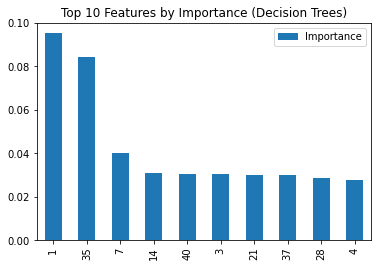

In [41]:
feature_imp = pd.DataFrame({'Feature': X_resampled.columns, 'Importance': clf.feature_importances_})
feature_imp.sort_values(by='Importance', inplace=True, ascending=False)
top_10_feat = feature_imp.head(10)
col_list = list(top_10_feat['Feature'])
print(top_10_feat)
top_10_feat.plot.bar()
plt.title("Top 10 Features by Importance (Decision Trees)")

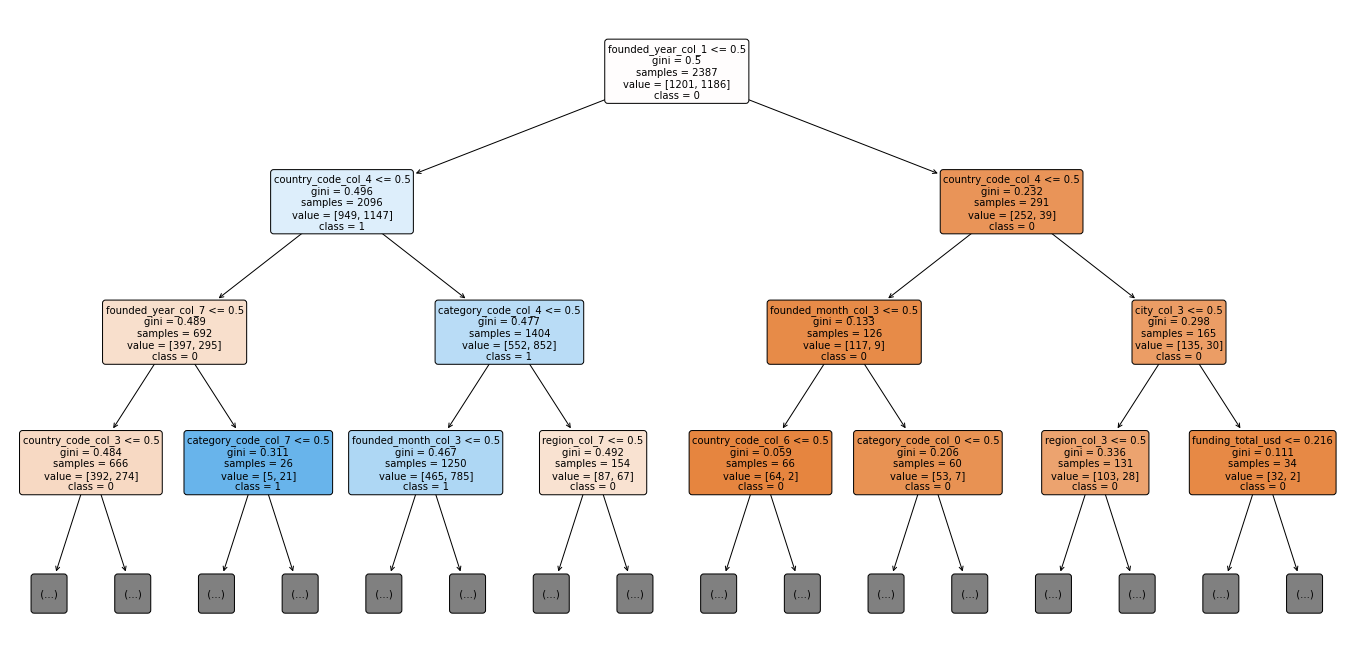

In [42]:
plt.figure(figsize=(24,12))

plot_tree(clf, max_depth=3, fontsize=10, feature_names=clf.feature_names_in_, 
          class_names=["0","1"], filled=True, rounded=True)
plt.show()

We consider only these top 10 features for the final model

##### Final Model - Quadratic Discriminant Analysis (with Top 10 features)

In [43]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train[col_list], y_train)
score = clf.score(X_test[col_list], y_test)
print("Accuracy = "+ str(round(score*100,2)) + "%")

Accuracy = 62.48%


              precision    recall  f1-score   support

           0       0.72      0.37      0.49       291
           1       0.59      0.87      0.70       306

    accuracy                           0.62       597
   macro avg       0.66      0.62      0.60       597
weighted avg       0.66      0.62      0.60       597



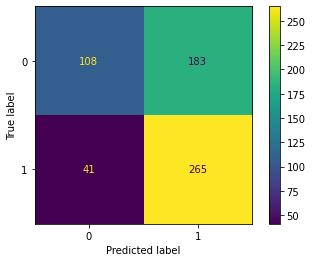

In [44]:
y_pred = clf.predict(X_test[col_list])
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test[col_list], y_test)

### Conclusion for Data Modeling

*   The QDA Classifier performs significantly better than the Decision Trees Classifier with respect to accuracy and F1-score
*   Funding Amount and the Founded Year seem to be the most important features for predicting acquisition status, with feature importance values > 0.7
*   Other features such as Category Code are relatively significant​